# Post-Processing (General)

#### Updated: May 16, 2023

#  

Post-processing pipeline after subdirectories are OCR processed:

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Generate processed_inventory - RUN BEFORE starting OCR process step:

In [3]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

R014207711
R014207807
R014207808
R014207810
R014207811
R014207813
R014207817
R014207818
R014207819
R014207820
R014207822
R014207825
R014207826
R014207827
R014207828
R014207829
R014207830
R014207831
R014207833
R014207834
R014207835
R014207836
R014207837
R014207838
R014207839
R014207843
R014207886
R014207892
R014207941
R014207944
R014207945
R014207950
R014207952
R014207961
R014207963
R014207969
R028224481


In [4]:
print(len(df_inventory))
df_inventory.head()

1977


,Directory,Subdirectory,images,subdir_id
0,R014207711,24,256,R014207711_24
1,R014207711,25,499,R014207711_25
2,R014207711,27,96,R014207711_27
3,R014207711,28,103,R014207711_28
4,R014207711,29,341,R014207711_29


In [5]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

#  

#### Concatenate 'OCR pass' results - START HERE after OCR processing step:

In [3]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_total.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_total.csv', index=False)
df_result.to_csv(resultDir + 'result_total.csv', index=False)

#  

#### Reduce columns:

In [4]:
df_result = pd.read_csv(resultDir + 'result_total.csv')
print(len(df_result))
df_result.head()

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_22416\4288959191.py:1: DtypeWarning: Columns (38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_result = pd.read_csv(resultDir + 'result_total.csv')


20944


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_code,station_number,rotated_metadata,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,1.500000,2046.875,0.0,0.0,4.0,0.0,2.0,2.0,2.0,2.0,...,70.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.500000,2125.000,0.0,0.0,2.0,2.0,2.0,0.0,4.0,2.0,...,71.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.555556,562.500,7.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,...,91.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.459677,2046.875,11.0,2.0,10.0,1.0,0.0,4.0,4.0,4.0,...,92.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.500000,2281.250,0.0,0.0,8.0,0.0,4.0,4.0,4.0,4.0,...,93.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
11812,R014207837,3979-50A,103.png,loss,1.729839,1427.659574,NaN,NaN,NaN,NaN,...,s0,61,091,15,47,a5,NaN,NaN,NaN,OCR read metadata contains letters
19899,R014207963,1548-1B,50.png,num,1.737903,1292.000000,NaN,0.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3803,R014207811,5095,186.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ionogram_content_extraction.extract_select_par...,NaN
16076,R014207944,2027-13B,39.png,num,1.677419,1288.461538,NaN,3.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9044,R014207829,4322-8,275.png,loss,1.504032,1245.714286,NaN,NaN,NaN,NaN,...,06,64,294,0n,35,57,bottom,True,NaN,OCR read metadata contains letters
20886,R028224481,4927,34.png,loss,1.500000,931.818182,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
6531,R014207822,3473-19A-2,69.png,num,1.500000,1017.391304,NaN,2.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3745,R014207811,5095,50.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata_translation.determine_leftside_metada...,NaN
12779,R014207838,4557-50-2,151.png,loss,1.500000,978.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
3985,R014207813,5004,246.png,loss,4.216981,1453.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [6]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [7]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

3203


In [8]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

4849


In [9]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

589


In [10]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

1933


In [11]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

10370


In [12]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

20944

#### num2 - check timestamp components, construct timestamp:

In [13]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
14023,66.0,015,03,53,59.0
5059,67.0,245,18,34,7.0
11126,68.0,096,18,12,54
12344,67.0,137,10,44,11
8276,68.0,047,03,22.0,8.0
12388,61.0,135,09,28,32
10681,68.0,084,21.0,21.0,9.0
5261,69.0,155,10,23,40
11995,61,099,15,22,56
9466,67,043,05,25,15


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

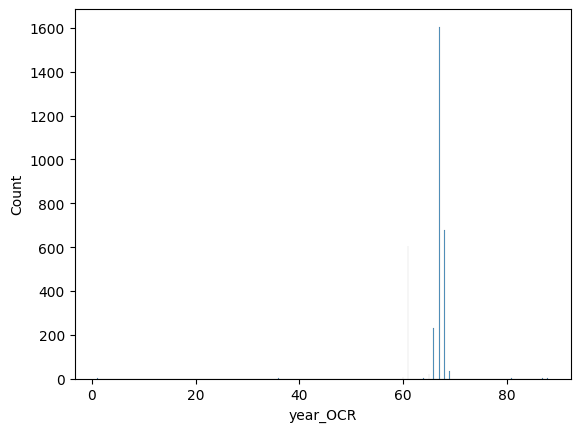

In [14]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [15]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [16]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
1946,1968.0,68.0
13421,NaN,NaN
13081,1967.0,67.0
13083,1967.0,67.0
944,1968.0,68.0
7291,1966.0,66.0
14214,1966.0,66.0
11640,1967.0,67.0
11998,NaN,NaN
12301,1967.0,67.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

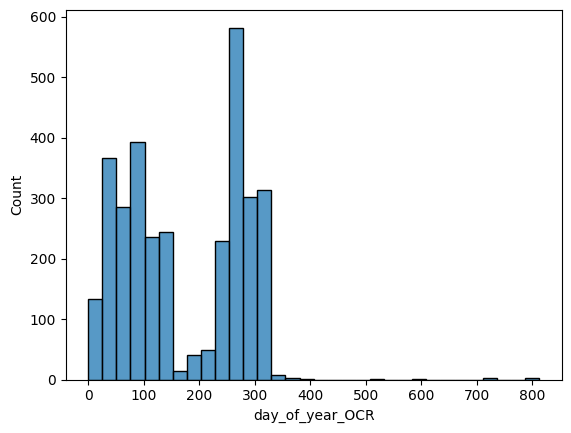

In [17]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
12216,136.0,136.0
9794,50.0,50.0
1894,292.0,292.0
11874,98.0,98.0
8346,35.0,35.0
11662,124.0,124.0
13950,13.0,13.0
11521,118.0,118.0
1010,216.0,216.0
9548,46.0,46.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

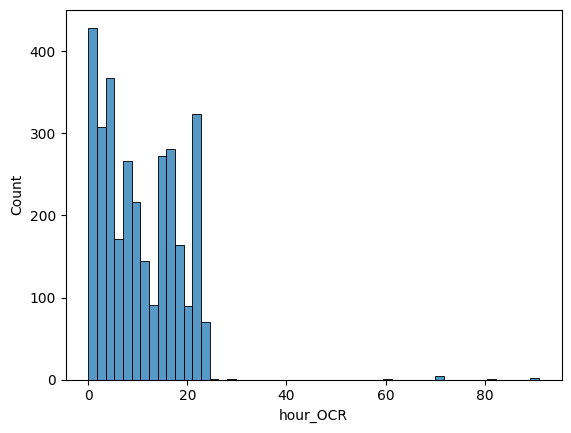

In [19]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
11517,4.0,4.0
10049,2.0,2.0
5000,5.0,5.0
13966,2.0,2.0
4487,0.0,0.0
9981,23.0,23.0
8978,13.0,13.0
12208,10.0,10.0
11307,0.0,0.0
11249,1.0,1.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

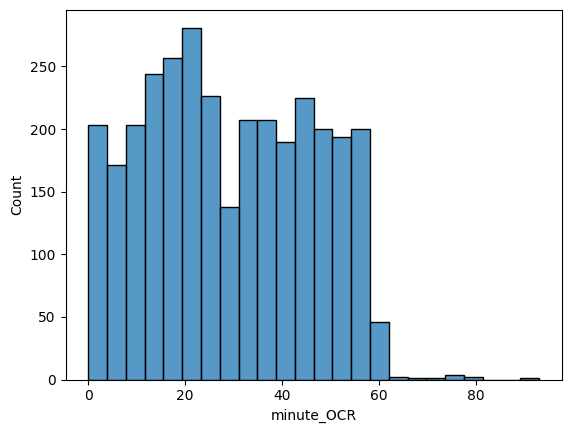

In [21]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
7709,1.0,1.0
13257,45.0,45.0
8371,23.0,23.0
8356,19.0,19.0
14151,29.0,29.0
11790,49.0,49.0
13598,46.0,46.0
12966,50.0,50.0
11561,9.0,9.0
12024,18.0,18.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

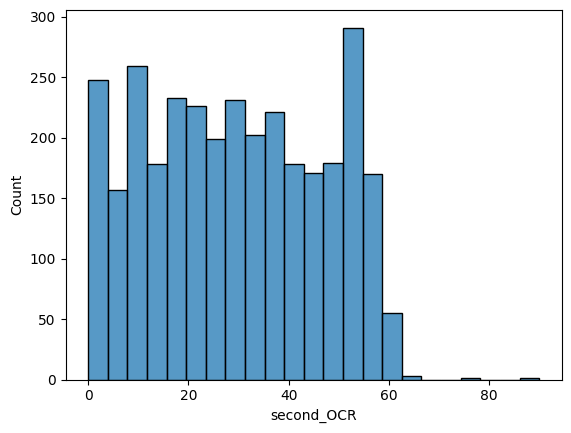

In [23]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
10832,0.0,0.0
13422,55.0,55.0
11482,35.0,35.0
13101,31.0,31.0
8184,30.0,30.0
11919,20.0,20.0
4557,20.0,20.0
11991,47.0,47.0
9745,33.0,33.0
10083,49.0,49.0


construct timestamp:

In [25]:
df_num2['month_day'] = pd.to_datetime(df_num2['day_of_year'], format='%j').dt.strftime('%m-%d')
df_num2['month'] = df_num2['month_day'].str.split('-').str[0]
df_num2['day'] = df_num2['month_day'].str.split('-').str[1]
df_num2['Timestamp'] = pd.to_datetime(df_num2[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp']].sample(10)

,year,month,day,hour,minute,second,Timestamp
10014,NaN,02,22,4.0,33.0,21.0,NaT
10761,1968.0,03,28,16.0,8.0,22.0,1968-03-28 16:08:22
8784,NaN,09,14,2.0,32.0,37.0,NaT
8036,1967.0,11,06,8.0,5.0,22.0,1967-11-06 08:05:22
12262,1967.0,05,16,21.0,4.0,47.0,1967-05-16 21:04:47
9007,1967.0,10,13,1.0,53.0,36.0,1967-10-13 01:53:36
8708,NaN,09,03,6.0,55.0,19.0,NaT
10449,1968.0,02,24,15.0,33.0,5.0,1968-02-24 15:33:05
4546,NaN,09,24,17.0,37.0,28.0,NaT
13943,1966.0,01,14,8.0,38.0,8.0,1966-01-14 08:38:08


#    

#### num - check timestamp components, construct timestamp:

In [26]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
16055,2.0,4.0,0.0,2.0,3.0,2.0,4.0,0.0,1.0,1.0
19630,4.0,0.0,5.0,4.0,2.0,0.0,2.0,1.0,2.0,5.0
20642,3.0,3.0,0.0,5.0,0.0,2.0,4.0,1.0,5.0,1.0
16722,5.0,0.0,4.0,9.0,0.0,5.0,4.0,4.0,3.0,2.0
16872,4.0,2.0,5.0,2.0,0.0,7.0,0.0,1.0,0.0,3.0
15211,4.0,1.0,4.0,0.0,0.0,6.0,4.0,9.0,5.0,7.0
16555,0.0,4.0,8.0,1.0,0.0,2.0,8.0,1.0,5.0,8.0
15758,4.0,2.0,5.0,6.0,1.0,9.0,2.0,1.0,0.0,7.0
16961,4.0,2.0,5.0,4.0,0.0,6.0,2.0,8.0,0.0,9.0
17002,1.0,4.0,2.0,5.0,4.0,1.0,7.0,3.0,2.0,3.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

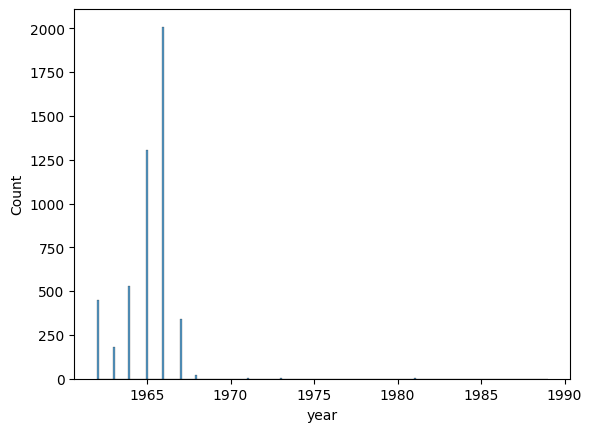

In [27]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [28]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
6537,1964.0,2.0
17353,1966.0,4.0
16891,1966.0,4.0
20546,1965.0,3.0
18861,1965.0,3.0
20185,1965.0,3.0
16010,1968.0,6.0
18031,1965.0,3.0
18083,1965.0,3.0
15830,1966.0,4.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

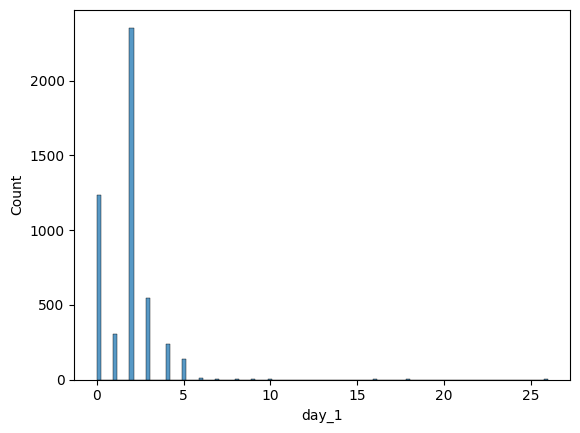

In [29]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [30]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

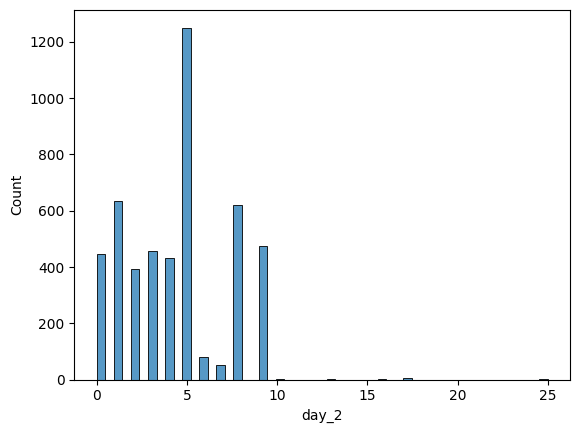

In [31]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [32]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

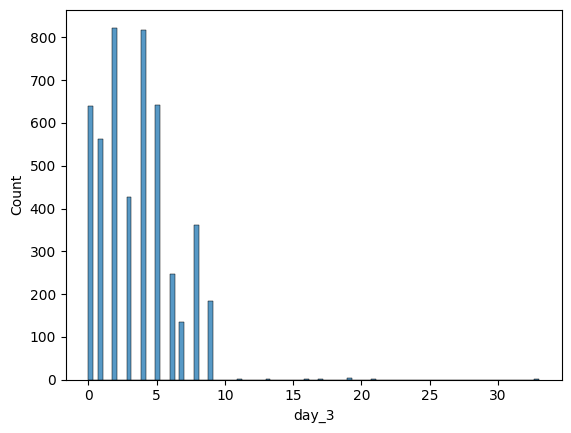

In [33]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [34]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [35]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

4849


,day_of_year,day_1,day_2,day_3
15744,256.0,2.0,5.0,6.0
18867,294.0,2.0,9.0,4.0
19177,52.0,0.0,5.0,2.0
15754,256.0,2.0,5.0,6.0
16168,350.0,3.0,5.0,0.0
18656,292.0,2.0,9.0,2.0
15215,140.0,1.0,4.0,0.0
14931,213.0,2.0,1.0,3.0
16802,NaN,4.0,8.0,0.0
19649,54.0,0.0,5.0,4.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

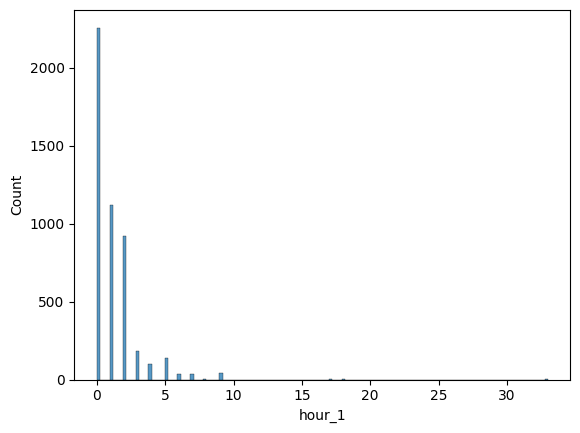

In [36]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [37]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

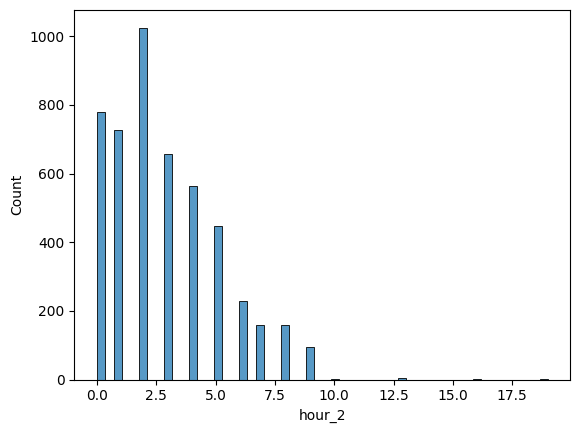

In [38]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [39]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [40]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

4849


,hour,hour_1,hour_2
20481,18.0,1.0,8.0
19463,21.0,2.0,1.0
16428,NaN,4.0,0.0
16077,4.0,0.0,4.0
19897,8.0,0.0,8.0
16367,17.0,1.0,7.0
16378,0.0,0.0,0.0
19748,1.0,0.0,1.0
16124,22.0,2.0,2.0
15911,NaN,3.0,5.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

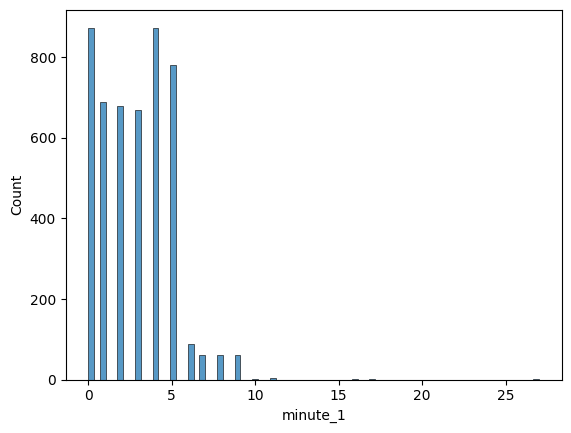

In [41]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [42]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

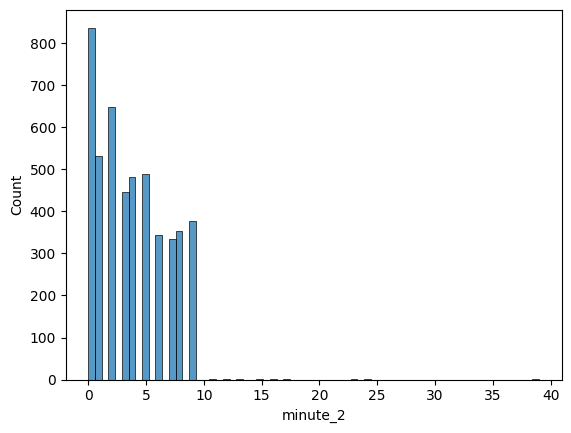

In [43]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [44]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [45]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

4849


,minute,minute_1,minute_2
19863,41.0,4.0,1.0
18091,30.0,3.0,0.0
15602,18.0,1.0,8.0
15298,37.0,3.0,7.0
6933,42.0,4.0,2.0
15720,34.0,3.0,4.0
16630,10.0,1.0,0.0
15961,52.0,5.0,2.0
19411,20.0,2.0,0.0
6365,40.0,4.0,0.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

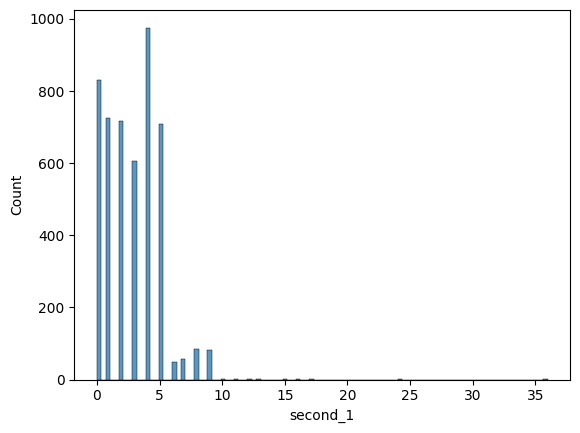

In [46]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [47]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

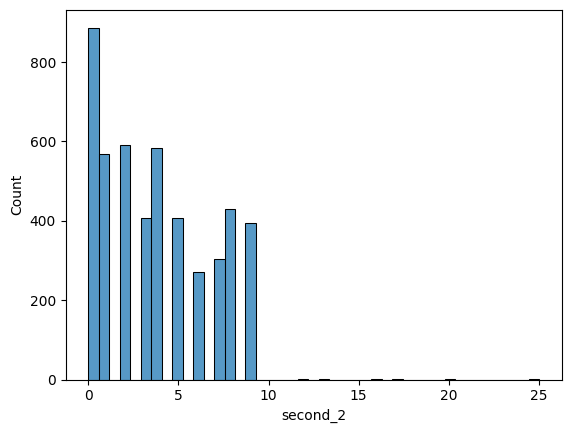

In [48]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [49]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [50]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

4849


,second,second_1,second_2
6344,42.0,4.0,2.0
19292,48.0,4.0,8.0
18177,44.0,4.0,4.0
18688,24.0,2.0,4.0
17067,22.0,2.0,2.0
14540,0.0,0.0,0.0
15839,6.0,0.0,6.0
20204,44.0,4.0,4.0
19579,35.0,3.0,5.0
18732,45.0,4.0,5.0


construct timestamp:

In [51]:
df_num['month_day'] = pd.to_datetime(df_num['day_of_year'], format='%j').dt.strftime('%m-%d')
df_num['month'] = df_num['month_day'].str.split('-').str[0]
df_num['day'] = df_num['month_day'].str.split('-').str[1]
df_num['Timestamp'] = pd.to_datetime(df_num[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp']].sample(10)

,year,month,day,hour,minute,second,Timestamp
16108,1964.0,12,27,4.0,22.0,11.0,1964-12-27 04:22:11
18175,1965.0,10,13,10.0,42.0,9.0,1965-10-13 10:42:09
18934,1965.0,10,18,0.0,57.0,4.0,1965-10-18 00:57:04
19544,1966.0,03,25,5.0,47.0,10.0,1966-03-25 05:47:10
15499,1966.0,08,02,11.0,0.0,55.0,1966-08-02 11:00:55
19346,1963.0,NaN,NaN,NaN,5.0,NaN,NaT
18188,1965.0,10,13,10.0,45.0,39.0,1965-10-13 10:45:39
20578,1965.0,10,31,1.0,45.0,30.0,1965-10-31 01:45:30
6895,1964.0,08,12,4.0,22.0,42.0,1964-08-12 04:22:42
18185,1965.0,10,13,10.0,44.0,47.0,1965-10-13 10:44:47


#### dot - check timestamp components, construct timestamp:

In [52]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
18435,NaN,1.0,8.0,8.0,8.0,9.0,1.0,0.0,25.0,0.0,NaN
17676,NaN,1.0,12.0,8.0,20.0,4.0,0.0,12.0,12.0,13.0,NaN
17690,NaN,1.0,4.0,4.0,4.0,8.0,0.0,0.0,13.0,1.0,NaN
17501,NaN,1.0,8.0,8.0,8.0,8.0,8.0,0.0,9.0,1.0,NaN
18286,NaN,1.0,8.0,8.0,8.0,10.0,8.0,9.0,0.0,0.0,NaN
17588,NaN,1.0,4.0,8.0,5.0,8.0,4.0,8.0,12.0,8.0,NaN
17728,NaN,1.0,8.0,0.0,0.0,8.0,16.0,0.0,8.0,1.0,NaN
17453,NaN,1.0,12.0,4.0,12.0,0.0,9.0,8.0,20.0,8.0,NaN
17548,NaN,4.0,0.0,0.0,8.0,0.0,0.0,0.0,9.0,16.0,NaN
18227,NaN,1.0,8.0,8.0,8.0,8.0,9.0,0.0,1.0,0.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

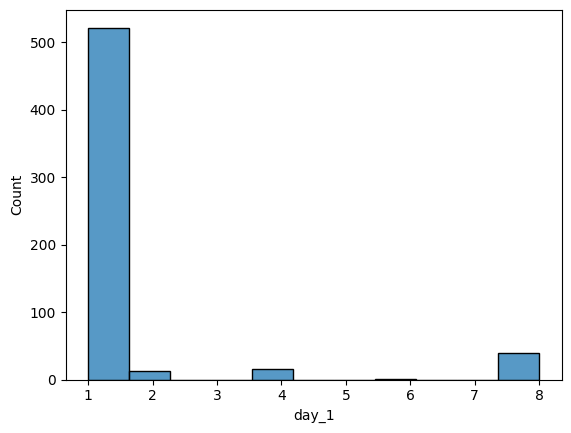

In [53]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [54]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

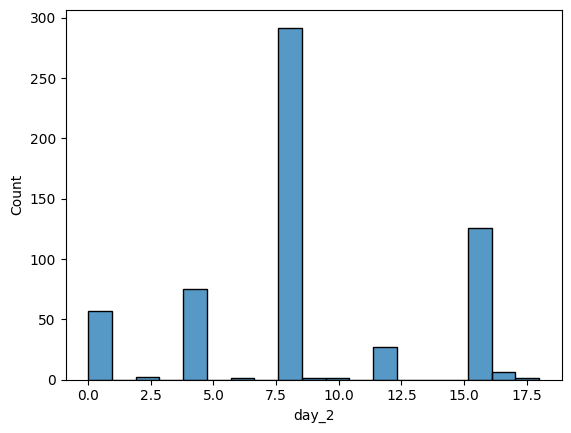

In [55]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [56]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

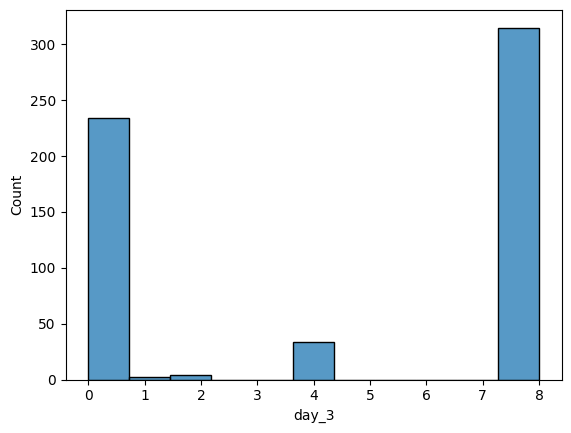

In [57]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [58]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [59]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

589


,day_of_year,day_1,day_2,day_3
18282,180.0,1,8.0,0
17673,188.0,1,8.0,8
18302,180.0,1,8.0,0
18248,NaN,1,NaN,8
18411,180.0,1,8.0,0
17489,180.0,1,8.0,0
17670,188.0,1,8.0,8
18484,188.0,1,8.0,8
18464,188.0,1,8.0,8
17678,NaN,1,NaN,8


year - infer from day:

In [60]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_22416\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_22416\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962


,year,day_of_year,day_1,day_2,day_3
18461,NaN,NaN,1,NaN,8
17603,1963.0,180.0,1,8.0,0
18334,1963.0,180.0,1,8.0,0
17651,1963.0,180.0,1,8.0,0
17640,1963.0,180.0,1,8.0,0
18338,NaN,NaN,1,NaN,8
18471,1963.0,162.0,1,6.0,2
18262,1963.0,188.0,1,8.0,8
17488,1963.0,140.0,1,4.0,0
18413,NaN,NaN,1,NaN,8


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

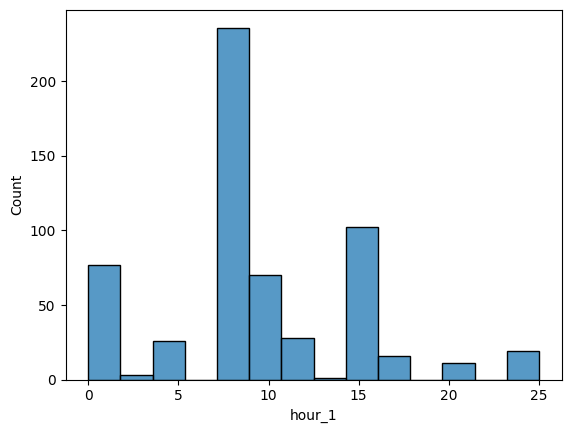

In [61]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [62]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

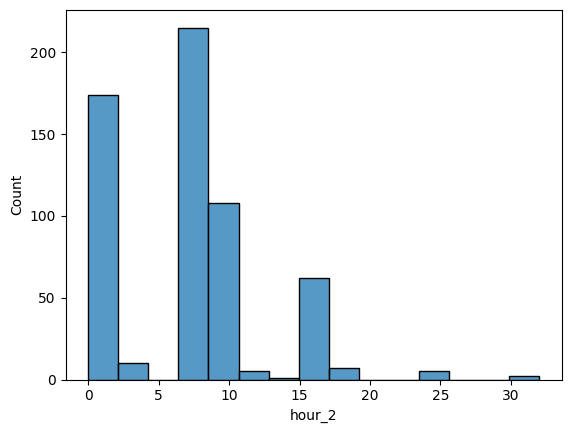

In [63]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [64]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [65]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

589


,hour,hour_1,hour_2
17748,NaN,8.0,8.0
18305,NaN,8.0,9.0
18421,NaN,NaN,9.0
18352,NaN,8.0,8.0
17711,NaN,NaN,0.0
18426,NaN,8.0,9.0
17577,18.0,1.0,8.0
18417,NaN,9.0,8.0
18219,NaN,9.0,8.0
17459,NaN,NaN,0.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

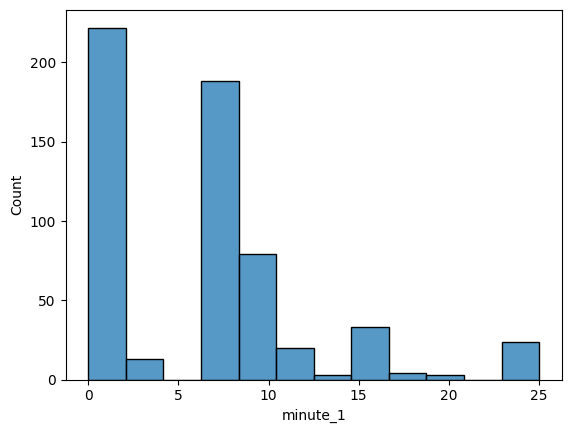

In [66]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [67]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

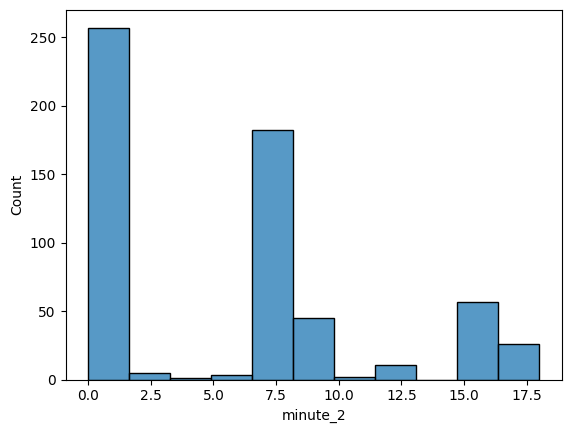

In [68]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [69]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [70]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

589


,minute,minute_1,minute_2
18480,NaN,NaN,0.0
17484,9.0,0.0,9.0
18417,NaN,9.0,1.0
17708,NaN,8.0,NaN
17457,NaN,9.0,8.0
17659,NaN,8.0,8.0
17670,NaN,NaN,8.0
17490,NaN,NaN,0.0
17605,0.0,0.0,0.0
17641,NaN,8.0,NaN


second:

<Axes: xlabel='second_1', ylabel='Count'>

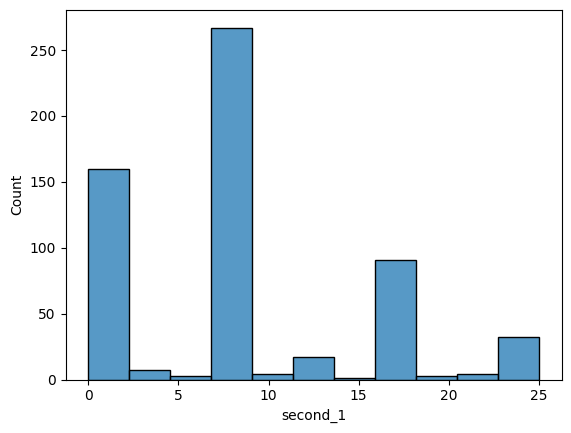

In [71]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [72]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

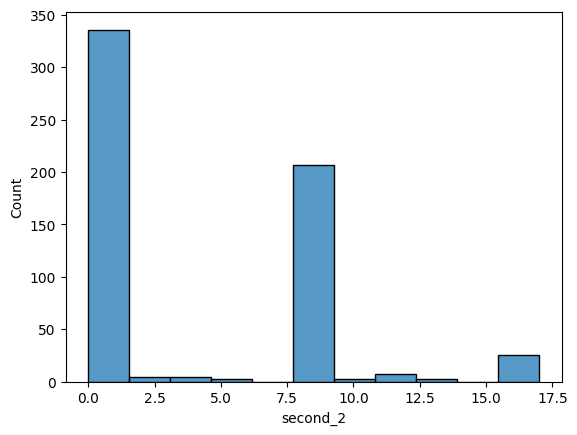

In [73]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [74]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [75]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

589


,second,second_1,second_2
18288,8.0,0.0,8.0
17525,NaN,8.0,8.0
18228,18.0,1.0,8.0
17506,NaN,8.0,0.0
18289,10.0,1.0,0.0
17638,NaN,8.0,1.0
18388,NaN,9.0,8.0
17514,NaN,9.0,9.0
18363,NaN,NaN,0.0
18254,NaN,8.0,0.0


construct timestamp:

In [76]:
df_dot['month_day'] = pd.to_datetime(df_dot['day_of_year'], format='%j').dt.strftime('%m-%d')
df_dot['month'] = df_dot['month_day'].str.split('-').str[0]
df_dot['day'] = df_dot['month_day'].str.split('-').str[1]
df_dot['Timestamp'] = pd.to_datetime(df_dot[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp']].sample(10)

,year,month,day,hour,minute,second,Timestamp
18441,1963.0,07,07,NaN,NaN,NaN,NaT
17600,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18347,NaN,NaN,NaN,NaN,NaN,11.0,NaT
18224,NaN,NaN,NaN,NaN,NaN,9.0,NaT
17495,NaN,NaN,NaN,NaN,NaN,NaN,NaT
17566,1963.0,06,29,NaN,9.0,NaN,NaT
18264,1963.0,06,29,NaN,0.0,1.0,NaT
17460,NaN,NaN,NaN,NaN,NaN,18.0,NaT
17681,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18269,NaN,NaN,NaN,NaN,9.0,NaN,NaT


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

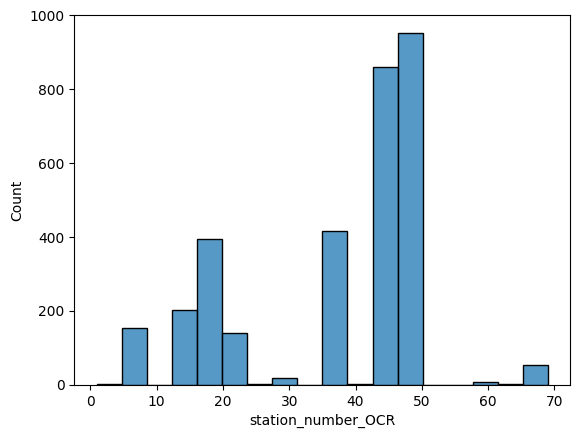

In [77]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [78]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
8176,21.0,21.0
11545,19.0,19.0
1863,50.0,50.0
8366,37.0,37.0
10496,15.0,15.0
8122,21.0,21.0
9833,43.0,43.0
8077,21.0,21.0
13412,50.0,50.0
14279,38.0,38.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

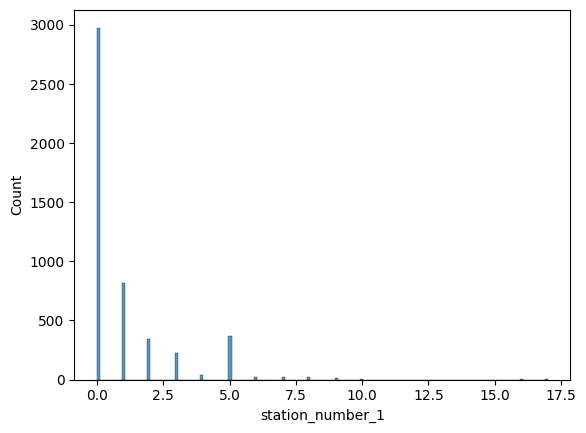

In [79]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [80]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

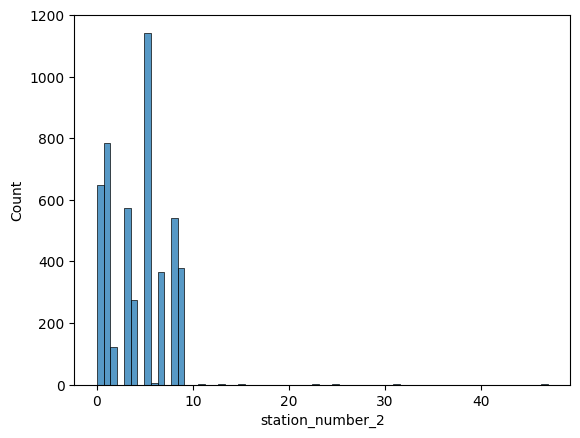

In [81]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [82]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [83]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

4849


,station_number,station_number_1,station_number_2
18774,7.0,0.0,7.0
18924,7.0,0.0,7.0
16456,50.0,5.0,0.0
18006,9.0,0.0,9.0
15539,3.0,0.0,3.0
20226,13.0,1.0,3.0
15012,0.0,0.0,0.0
6473,35.0,3.0,5.0
18956,1.0,0.0,1.0
18967,1.0,0.0,1.0


dot:

In [84]:
df_dot[['station_number']].sample(10)

,station_number
18371,24.0
17654,1.0
18287,16.0
18279,8.0
18382,32.0
17622,1.0
18373,32.0
17479,1.0
17571,9.0
18358,8.0


#  

#### Recombine results:

In [85]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

20944


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,details,year,day_of_year,hour,minute,second,month_day,month,day,Timestamp
11231,R014207835,4060-19,142.png,num2,1.838710,1008.510638,19.0,NaN,NaN,NaN,...,NaN,1967.0,19.0,1.0,15.0,35.0,01-19,01,19,1967-01-19 01:15:35
7288,R014207827,3790-13A,89.png,loss,1.540323,1376.595745,NaN,NaN,NaN,NaN,...,metadata could not be read by OCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
18649,R014207961,1077-B,175.png,num,1.500000,1244.230769,7.0,0.0,7.0,3.0,...,NaN,1965.0,291.0,14.0,12.0,43.0,10-18,10,18,1965-10-18 14:12:43
20091,R014207969,1269-13B,216.png,num,1.528226,1244.230769,13.0,1.0,3.0,3.0,...,NaN,1965.0,213.0,11.0,54.0,54.0,08-01,08,01,1965-08-01 11:54:54
2190,R014207810,5119,234.png,loss,1.608871,854.545455,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
17700,R014207961,1033,388.png,dot,1.540323,1296.000000,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaT
19353,R014207963,1547-5A,169.png,num,1.754032,1482.692308,5.0,0.0,5.0,4.0,...,NaN,1966.0,85.0,4.0,28.0,50.0,03-26,03,26,1966-03-26 04:28:50
8535,R014207829,4320-8,16.png,loss,1.500000,711.320755,NaN,NaN,NaN,NaN,...,OCR read metadata contains letters,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
17691,R014207961,1033,38.png,dot,1.641129,1440.000000,9.0,NaN,NaN,NaN,...,NaN,1963.0,188.0,NaN,NaN,1.0,07-07,07,07,NaT
18857,R014207961,1077-B,368.png,num,1.649194,1148.076923,7.0,0.0,7.0,3.0,...,NaN,1965.0,294.0,23.0,54.0,41.0,10-21,10,21,1965-10-21 23:54:41


#  

#### Retrieve station details:

In [86]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [87]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [88]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
39
1963-04-25 00:00:00
70
1963-08-06 00:00:00
88
1965-07-01 00:00:00
409
After 1965-07-01 00:00:00
6470


In [89]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [90]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

6470


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
3809,5.0,1967-02-18 03:54:26,QUI,"Quito, Ecuador",0.6S,78.6W
5163,1.0,1966-02-20 21:56:05,BPT,"Blossom Point, MD, USA",38.4N,77.1W
1903,43.0,1968-02-27 05:23:01,RES,"Resolute Bay, NT, Canada",74.7N,95W
5801,1.0,1966-02-24 20:55:20,BPT,"Blossom Point, MD, USA",38.4N,77.1W
597,50.0,1968-10-19 00:46:34,OTT,"Ottawa, Canada",45.4N,75.7W
6045,13.0,1965-08-01 11:56:59,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
5375,1.0,1966-02-20 00:49:55,BPT,"Blossom Point, MD, USA",38.4N,77.1W
1399,8.0,1967-10-16 02:05:54,SNT,"Santiago, Chile",33.2S,70.1W
5459,5.0,1966-03-26 04:29:08,QUI,"Quito, Ecuador",0.6S,78.6W
3194,18.0,1966-05-16 04:18:43,WOO,"Woomera, Australia",31.1S,136.8E


#  

#### Save:

In [91]:
df_result4 = df_result4.sort_values('Timestamp').reset_index(drop=True)
df_result4.to_csv(resultDir + 'result_total.csv', index=False)